# Test environnement Tracking avec CACLA

Reproduction de l'environnement de test pour le papier https://dspace.library.uu.nl/bitstream/handle/1874/25514/wiering_07_reinforcementlearning.pdf

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import sys

sys.path.insert(0, '../')
from utils.Tracking import Tracking
from utils.Critic import CriticNetwork
from utils.Actor import ActorNetwork
from utils.CACLA import CACLA

from tqdm import tqdm

## hyper paramètres

In [8]:
env = Tracking()
actor_network = ActorNetwork(
    nb_neurons = 12,
    action_space = env.action_space,
    observation_space = env.observation_space
)

critic_network = CriticNetwork(
    nb_neurons = 12,
    observation_space = env.observation_space
)

cacla = CACLA(
    learning_rate_critic = 0.01,
    learning_rate_actor = 0.01,
    discount_factor = 0.95,
    sigma = 0.1,
    nb_episode = 500,
    test_frequency = 10,
    env = env,
    actor_network = actor_network,
    critic_network = critic_network,
)

## Apprentissage

In [9]:
cacla.learning()

0/500 - iteration : 300 - rewards value test : -48.48117255335074 - best value : -10000000000.0
10/500 - iteration : 3300 - rewards value test : -42.22571859966178 - best value : -48.48117255335074
20/500 - iteration : 6300 - rewards value test : -48.51296955014787 - best value : -42.22571859966178
30/500 - iteration : 9300 - rewards value test : -48.42719972913964 - best value : -42.22571859966178
40/500 - iteration : 12300 - rewards value test : -48.43291775213413 - best value : -42.22571859966178
50/500 - iteration : 15007 - rewards value test : -5.961033388545808 - best value : -42.22571859966178
60/500 - iteration : 15077 - rewards value test : -5.998391302159066 - best value : -5.961033388545808
70/500 - iteration : 15147 - rewards value test : -6.042896509910385 - best value : -5.961033388545808
80/500 - iteration : 15217 - rewards value test : -5.845871329462158 - best value : -5.961033388545808
90/500 - iteration : 15580 - rewards value test : -6.108318918180568 - best value :

In [20]:
dist_max = -200
dist_min = 0
current_dist = -48
r = 1 - ( current_dist / (dist_max - dist_min))
print(r)

0.76


## Affichage des rewards

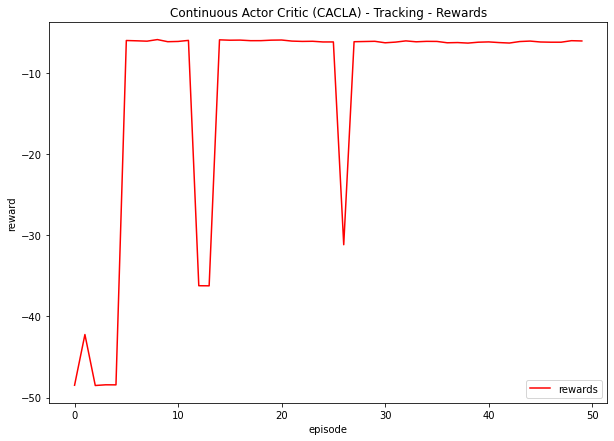

In [11]:
plt.figure(figsize=(10,7))
plt.plot(cacla.list_rewards, c= 'r',label = 'rewards')
plt.legend()
plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Continuous Actor Critic (CACLA) - Tracking - Rewards')
plt.show()

## Démonstration de la simulation de l'agent dans l'environement

iteration : 7, reward :  -0.13762197739055854


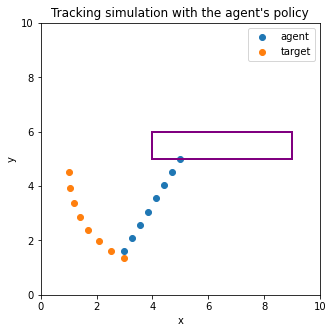

0.0752333695578012


In [12]:
state = env.reset()
done = False

list_x_agent = list()
list_y_agent = list()
list_x_target = list()
list_y_target = list()

nb_iter = 0
r = 0.0
list_x_agent.append(env.agent[0])
list_y_agent.append(env.agent[1])
list_x_target.append(env.target[0])
list_y_target.append(env.target[1])
while not done :
    state_t = torch.as_tensor(state , dtype=torch.float32)
    action =  cacla.best_model(state_t).detach().numpy()
    new_state, reward, done = env.step(action)
    r += reward
    list_x_agent.append(env.agent[0])
    list_y_agent.append(env.agent[1])
    list_x_target.append(env.target[0])
    list_y_target.append(env.target[1])
    state = new_state
    nb_iter += 1
    
print(f"iteration : {nb_iter}, reward : ",(r/300))
plt.figure(figsize=(5,5))
plt.scatter(list_x_agent,list_y_agent , label="agent")
plt.scatter(list_x_target,list_y_target, label='target')
rect=mpatches.Rectangle((4,5),5,1, 
                            fill=False,
                            color="purple",
                           linewidth=2)
                           #facecolor="red")
plt.gca().add_patch(rect)
plt.xticks([0, 2, 4, 6, 8, 10])
plt.yticks([0, 2, 4, 6, 8, 10])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Tracking simulation with the agent's policy")
plt.legend()
plt.show()
print((env.agent[0] - env.target[0])**2 + (env.agent[1] - env.target[1])**2)

## Etape par étape

In [ ]:
state = env.reset()
done = False

list_x_agent = list()
list_y_agent = list()
list_x_target = list()
list_y_target = list()

iteration = 0
while not done :
    state_t = torch.as_tensor(state , dtype=torch.float32)
    action =  cacla.best_model(state_t).detach().numpy()
    new_state, reward, done = env.step(action)
    state = new_state
    iteration += 1
    
    plt.figure(figsize=(4,4))
    # plt.scatter(list_x_target[0],list_y_target[0], color="red",label="first position target")
    plt.scatter(env.agent[0] ,env.agent[1], label="agent")
    plt.scatter(env.target[0],env.target[1], label='target')
    rect=mpatches.Rectangle((4,5),5,1, 
                            fill=False,
                            color="purple",
                           linewidth=2)
                           #facecolor="red")
    plt.gca().add_patch(rect)
    plt.xticks([0, 2, 4, 6, 8, 10])
    plt.yticks([0, 2, 4, 6, 8, 10])
    plt.legend()
    plt.show()

In [21]:
success = 0
fails = 0
nb_tests = 20


matrice_simulation_rewards = list()

for i in tqdm(range(nb_tests)) : 
    env = Tracking()
    actor_network = ActorNetwork(
        nb_neurons = 12,
        action_space = env.action_space,
        observation_space = env.observation_space
    )
    critic_network = CriticNetwork(
        nb_neurons = 12,
        observation_space = env.observation_space
    )
    cacla = CACLA(
        learning_rate_critic = 0.01,
        learning_rate_actor = 0.01,
        discount_factor = 0.95,
        sigma = 0.1,
        nb_episode = 500,
        test_frequency = 1,
        env = env,
        actor_network = actor_network,
        critic_network = critic_network,
        verbose_mode = False
    )
    cacla.learning()
    matrice_simulation_rewards.append(cacla.list_rewards)
    
    state = env.reset()
    done = False
    nb_iter = 0
    while not done :
        state_t = torch.as_tensor(state , dtype=torch.float32)
        action =  cacla.best_model(state_t).detach().numpy()
        new_state, reward, done = env.step(action)
        state = new_state
        nb_iter += 1
    
    if nb_iter == env.max_iteration :
        fails += 1
    else :
        success += 1    

100%|████████████████████████████████████████| 20/20 [1:02:23<00:00, 187.17s/it]


In [23]:
print(f"nombre de succes : {success}")
print(f"nombre d'echecs : {fails}")
print(f"ratio : {success/(success+fails)*100}%")

nombre de succes : 18
nombre d'echecs : 2
ratio : 90.0%


In [29]:
import numpy as np
def rewards_normalization(matrice_simulation_rewards) :
    dist_max = -200
    dist_min = 0
    arr = np.array(matrice_simulation_rewards)
    return 1 - ( arr / (dist_max - dist_min)).mean(axis=0)
l = rewards_normalization(matrice_simulation_rewards)

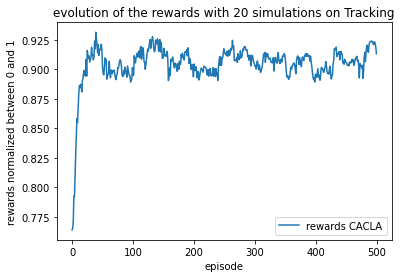

In [35]:
plt.figure()
plt.title(f"evolution of the rewards with {nb_tests} simulations on Tracking")
plt.xlabel("episode")
plt.ylabel("rewards normalized between 0 and 1")
plt.plot(l, label="rewards CACLA")
plt.legend()
plt.show()

In [36]:
print("mean rewards : ",l.mean())
print("std rewards : ",l.std())

mean rewards :  0.9044667729751401
std rewards :  0.01714671946060081
